In [29]:
## this is the phase 3 of the project

## first we will import the required functions from the utils file 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sfm_utils import (
    load_gray_image,
    build_intrinsics_from_image_size,
    get_feature_extractor,
)

# Dataset path (same as before)
DATASET_DIR = r"C:\Users\pc\OneDrive\Desktop\CV_Project\dataset2"


In [30]:

N_IMAGES = 63
image_names = [f"{i}.jpeg" for i in range(1, N_IMAGES + 1)]

print(f"[INFO] Using {N_IMAGES} sequentially numbered images.")
print(image_names[:10])

# ---- Build K_iphone from FIRST image resolution ----
first_img = load_gray_image(DATASET_DIR, image_names[0])
h, w = first_img.shape[:2]
print("Working image size:", w, "x", h)

f35 = 19.0             
sensor_width_35mm = 36.0 


img1_name = "1.jpeg"
img2_name = "2.jpeg"

img1 = load_gray_image(DATASET_DIR, img1_name)
img2 = load_gray_image(DATASET_DIR, img2_name)
h, w = img1.shape[:2]
K = build_intrinsics_from_image_size(w, h)

print("Intrinsic matrix K (iPhone-style) =\n", K)


[INFO] Using 63 sequentially numbered images.
['1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg', '10.jpeg']
Working image size: 1200 x 1600
Intrinsic matrix K (iPhone-style) =
 [[1.2e+03 0.0e+00 6.0e+02]
 [0.0e+00 1.2e+03 8.0e+02]
 [0.0e+00 0.0e+00 1.0e+00]]


In [31]:
feature, use_orb = get_feature_extractor()
print("[INFO] Using", "ORB" if use_orb else "SIFT", "for all images")

all_kps = {}
all_desc = {}

for idx, name in enumerate(image_names, start=1):
    gray = load_gray_image(DATASET_DIR, name)
    kps, desc = feature.detectAndCompute(gray, None)
    
    all_kps[idx] = kps
    all_desc[idx] = desc
    
    print(f"Image {idx:02d}: {name} -> {len(kps)} keypoints")

print("\n[INFO] Precomputed features for", len(all_kps), "images.")


[INFO] Using SIFT for all images
Image 01: 1.jpeg -> 11621 keypoints
Image 02: 2.jpeg -> 9735 keypoints
Image 03: 3.jpeg -> 9136 keypoints
Image 04: 4.jpeg -> 9247 keypoints
Image 05: 5.jpeg -> 8916 keypoints
Image 06: 6.jpeg -> 8144 keypoints
Image 07: 7.jpeg -> 7434 keypoints
Image 08: 8.jpeg -> 6182 keypoints
Image 09: 9.jpeg -> 6574 keypoints
Image 10: 10.jpeg -> 6566 keypoints
Image 11: 11.jpeg -> 6706 keypoints
Image 12: 12.jpeg -> 7409 keypoints
Image 13: 13.jpeg -> 8068 keypoints
Image 14: 14.jpeg -> 8062 keypoints
Image 15: 15.jpeg -> 7187 keypoints
Image 16: 16.jpeg -> 7186 keypoints
Image 17: 17.jpeg -> 7050 keypoints
Image 18: 18.jpeg -> 5864 keypoints
Image 19: 19.jpeg -> 5337 keypoints
Image 20: 20.jpeg -> 5094 keypoints
Image 21: 21.jpeg -> 4396 keypoints
Image 22: 22.jpeg -> 4499 keypoints
Image 23: 23.jpeg -> 3447 keypoints
Image 24: 24.jpeg -> 3129 keypoints
Image 25: 25.jpeg -> 3237 keypoints
Image 26: 26.jpeg -> 3164 keypoints
Image 27: 27.jpeg -> 3153 keypoints
Ima

In [32]:
cameras = {}
points3d = {}
observations = {}
keypoint_to_point = {}



[INFO] 1↔2: 2881 good matches


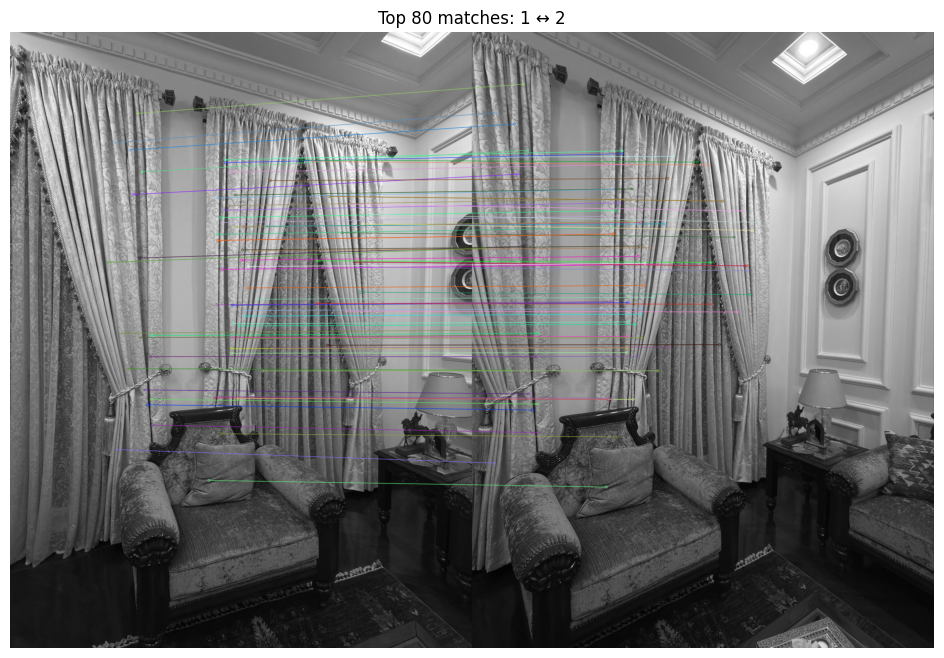

pts1 shape: (2881, 2) pts2 shape: (2881, 2)
[INFO] E inliers: 2595 / 2881
E =
 [[-0.00530767 -0.10414663 -0.01255416]
 [-0.14224814  0.00206461 -0.69252207]
 [ 0.0175911   0.69915683 -0.00351589]]
Recovered R_2 =
 [[ 0.93916826 -0.00646919 -0.34339646]
 [ 0.00742073  0.9999714   0.00145694]
 [ 0.34337721 -0.00391656  0.93918941]]
Recovered t_2 =
 [[ 0.98890616]
 [-0.01867522]
 [ 0.14736294]]


In [33]:
## recovering the pose bw img1 and img2 -> this is the same as phase 2 (copy and pasted)

if use_orb:
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
else:
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

def match_desc(desc1, desc2, ratio_thresh=0.75):
    """KNN match + Lowe's ratio test."""
    knn = bf.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in knn:
        if m.distance < ratio_thresh * n.distance:
            good.append(m)
    return good

i1, i2 = 1, 2
kps1, desc1 = all_kps[i1], all_desc[i1]
kps2, desc2 = all_kps[i2], all_desc[i2]

good_matches = match_desc(desc1, desc2, ratio_thresh=0.75)
print(f"[INFO] 1↔2: {len(good_matches)} good matches")

good_sorted = sorted(good_matches, key=lambda m: m.distance)[:80]

img1_vis = load_gray_image(DATASET_DIR, image_names[i1-1])
img2_vis = load_gray_image(DATASET_DIR, image_names[i2-1])

vis12 = cv2.drawMatches(
    img1_vis, kps1,
    img2_vis, kps2,
    good_sorted, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(vis12, cmap='gray')
plt.title("Top 80 matches: 1 ↔ 2")
plt.axis('off')
plt.show()

pts1 = np.array([kps1[m.queryIdx].pt for m in good_matches], dtype=np.float64)
pts2 = np.array([kps2[m.trainIdx].pt for m in good_matches], dtype=np.float64)

print("pts1 shape:", pts1.shape, "pts2 shape:", pts2.shape)

E, mask_E = cv2.findEssentialMat(
    pts1, pts2,
    K,
    method=cv2.RANSAC,
    prob=0.999,
    threshold=1.0
)
inliers_E = mask_E.ravel() == 1
print(f"[INFO] E inliers: {np.sum(inliers_E)} / {len(mask_E)}")
print("E =\n", E)

pts1_in = pts1[inliers_E]
pts2_in = pts2[inliers_E]

_, R_2, t_2, mask_pose = cv2.recoverPose(E, pts1_in, pts2_in, K)
print("Recovered R_2 =\n", R_2)
print("Recovered t_2 =\n", t_2)


In [34]:
P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
P2 = K @ np.hstack([R_2, t_2])

pts1_T = pts1_in.T
pts2_T = pts2_in.T

points_4d = cv2.triangulatePoints(P1, P2, pts1_T, pts2_T)
points_3d = (points_4d[:3] / points_4d[3]).T            

print("Triangulated points_3d:", points_3d.shape)

X = points_3d.T

X_cam1 = X
z1 = X_cam1[2, :]

X_cam2 = R_2 @ X + t_2
z2 = X_cam2[2, :]

in_front = (z1 > 0) & (z2 > 0)
print("Points in front of both cameras:", np.sum(in_front), "/", X.shape[1])

points_3d_valid = points_3d[in_front]
print("Valid 3D points after cheirality:", points_3d_valid.shape)


Triangulated points_3d: (2595, 3)
Points in front of both cameras: 2594 / 2595
Valid 3D points after cheirality: (2594, 3)


In [35]:
next_point_id = 0

good_matches_inliers = [m for m, keep in zip(good_matches, inliers_E) if keep]
good_matches_final = [m for m, keep in zip(good_matches_inliers, in_front) if keep]

print("Final matches used for map points:", len(good_matches_final))
print("points_3d_valid:", points_3d_valid.shape)

assert len(good_matches_final) == points_3d_valid.shape[0]

cameras[1] = (np.eye(3), np.zeros((3, 1)))  # [I|0]
cameras[2] = (R_2, t_2)

for X, m in zip(points_3d_valid, good_matches_final):
    pid = next_point_id
    next_point_id += 1

    
    points3d[pid] = X

    kp_idx1 = m.queryIdx
    kp_idx2 = m.trainIdx

    observations[pid] = [(1, kp_idx1), (2, kp_idx2)]

    keypoint_to_point[(1, kp_idx1)] = pid
    keypoint_to_point[(2, kp_idx2)] = pid

print("[INFO] Two-view map initialized:")
print("  Cameras:", list(cameras.keys()))
print("  Num 3D points:", len(points3d))
print("  Example point id 0:", points3d[0] if len(points3d) > 0 else "None")


Final matches used for map points: 2594
points_3d_valid: (2594, 3)
[INFO] Two-view map initialized:
  Cameras: [1, 2]
  Num 3D points: 2594
  Example point id 0: [-1.49232164 -2.5481114   4.88992945]


PHASE 3 STARTS HERE. NOW WE HAVE BOTH CAM[0] AND CAM[1] CALIBRATED

In [36]:
## we need a helper to build 2d -> 3d correspondences for PnP
def build_pnp_correspondences(img_prev, img_curr, matches):
    obj_pts = []
    img_pts = []
    matches_pnp = []

    for m in matches:
        kp_prev = m.queryIdx  
        key = (img_prev, kp_prev)

        if key in keypoint_to_point:
            pid = keypoint_to_point[key]
            obj_pts.append(points3d[pid])                     
            img_pts.append(all_kps[img_curr][m.trainIdx].pt)
            matches_pnp.append(m)

    if len(obj_pts) == 0:
        return None, None, None

    return np.array(obj_pts, dtype=np.float64), \
           np.array(img_pts, dtype=np.float64), \
           matches_pnp


In [37]:
def triangulate_new_points(img_prev, img_curr, matches, R_prev, t_prev, R_curr, t_curr):
    P_prev = K @ np.hstack([R_prev, t_prev])
    P_curr = K @ np.hstack([R_curr, t_curr])

    new_points = []
    new_matches = []

    pts_prev = []
    pts_curr = []

    for m in matches:
        if (img_prev, m.queryIdx) in keypoint_to_point:
            continue

        pts_prev.append(all_kps[img_prev][m.queryIdx].pt)
        pts_curr.append(all_kps[img_curr][m.trainIdx].pt)
        new_matches.append(m)

    if len(pts_prev) < 5:
        return []

    pts_prev = np.array(pts_prev).T
    pts_curr = np.array(pts_curr).T

    pts_4d = cv2.triangulatePoints(P_prev, P_curr, pts_prev, pts_curr)
    pts_3d = (pts_4d[:3] / pts_4d[3]).T

    return list(zip(pts_3d, new_matches))


In [38]:
if use_orb:
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
else:
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

def match_two_images(desc1, desc2):
    knn = bf.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in knn:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    return good

for i in range(3, N_IMAGES + 1):
    prev = i - 1

    matches = match_two_images(all_desc[prev], all_desc[i])
    print(f"Matches between {prev} and {i}: {len(matches)}")

    # Step 2 — build 2D→3D correspondences for PnP
    obj_pts, img_pts, matches_pnp = build_pnp_correspondences(prev, i, matches)

    if obj_pts is None or len(obj_pts) < 6:
        print(f"[WARN] Not enough 2D-3D correspondences for image {i}. Skipping.")
        continue

    # Step 3 — Solve PnP
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        objectPoints=obj_pts,
        imagePoints=img_pts,
        cameraMatrix=K,
        distCoeffs=None,
        reprojectionError=3.0,
        flags=cv2.SOLVEPNP_ITERATIVE
    )

    if not success:
        continue

    R_i, _ = cv2.Rodrigues(rvec)
    t_i = tvec.reshape(3,1)

    cameras[i] = (R_i, t_i)

    R_prev, t_prev = cameras[prev]
    new_pts = triangulate_new_points(prev, i, matches, R_prev, t_prev, R_i, t_i)

    print(f"[INFO] Triangulated {len(new_pts)} new points.")

    global next_point_id

    for (X, m) in new_pts:
        pid = next_point_id
        next_point_id += 1

        points3d[pid] = X
        observations[pid] = [(prev, m.queryIdx), (i, m.trainIdx)]

        keypoint_to_point[(prev, m.queryIdx)] = pid
        keypoint_to_point[(i, m.trainIdx)] = pid

    print(f"[INFO] Total 3D points so far: {len(points3d)}")


Matches between 2 and 3: 1617
[INFO] Triangulated 952 new points.
[INFO] Total 3D points so far: 3546
Matches between 3 and 4: 1781
[INFO] Triangulated 1482 new points.
[INFO] Total 3D points so far: 5028
Matches between 4 and 5: 2887
[INFO] Triangulated 2205 new points.
[INFO] Total 3D points so far: 7233
Matches between 5 and 6: 2906
[INFO] Triangulated 1834 new points.
[INFO] Total 3D points so far: 9067
Matches between 6 and 7: 3096
[INFO] Triangulated 2190 new points.
[INFO] Total 3D points so far: 11257
Matches between 7 and 8: 2523
[INFO] Triangulated 1476 new points.
[INFO] Total 3D points so far: 12733
Matches between 8 and 9: 2315
[INFO] Triangulated 1618 new points.
[INFO] Total 3D points so far: 14351
Matches between 9 and 10: 2361
[INFO] Triangulated 1515 new points.
[INFO] Total 3D points so far: 15866
Matches between 10 and 11: 2507
[INFO] Triangulated 1702 new points.
[INFO] Total 3D points so far: 17568
Matches between 11 and 12: 2820
[INFO] Triangulated 1803 new point

In [39]:
cam_indices = sorted(cameras.keys())
cam_centers = []

for i in cam_indices:
    R_i, t_i = cameras[i]
    C_i = -R_i.T @ t_i
    cam_centers.append(C_i.reshape(3))

cam_centers = np.array(cam_centers)

# Collect all 3D points into a single array
all_points = np.array(list(points3d.values()))
print("Num cameras:", cam_centers.shape[0])
print("Num 3D points:", all_points.shape[0])


Num cameras: 63
Num 3D points: 82944


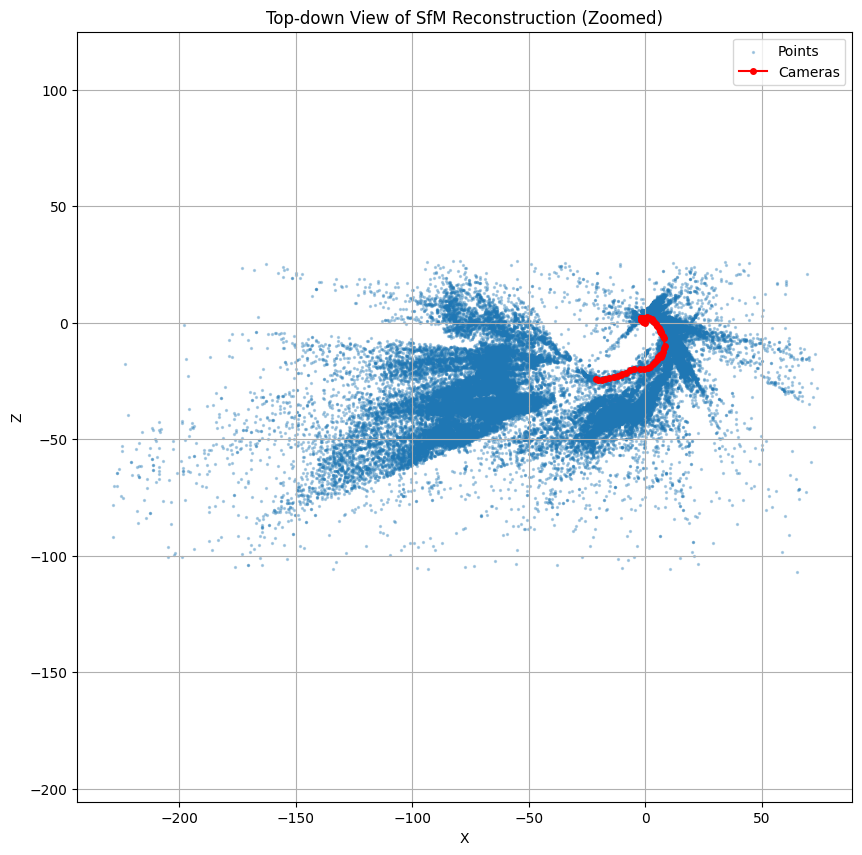

In [40]:
low = np.percentile(all_points, 0.5, axis=0)
high = np.percentile(all_points, 99.5, axis=0)

mask = np.all((all_points >= low) & (all_points <= high), axis=1)
filtered_points = all_points[mask]


plt.figure(figsize=(10, 10))

plt.scatter(filtered_points[:, 0],
            filtered_points[:, 2],
            s=2, alpha=0.3, label="Points")

plt.plot(cam_centers[:, 0],
         cam_centers[:, 2],
         '-o', markersize=4, color='red', label='Cameras')

plt.xlabel("X")
plt.ylabel("Z")
plt.title("Top-down View of SfM Reconstruction (Zoomed)")
plt.legend()
plt.grid(True)
plt.axis('equal')

plt.show()


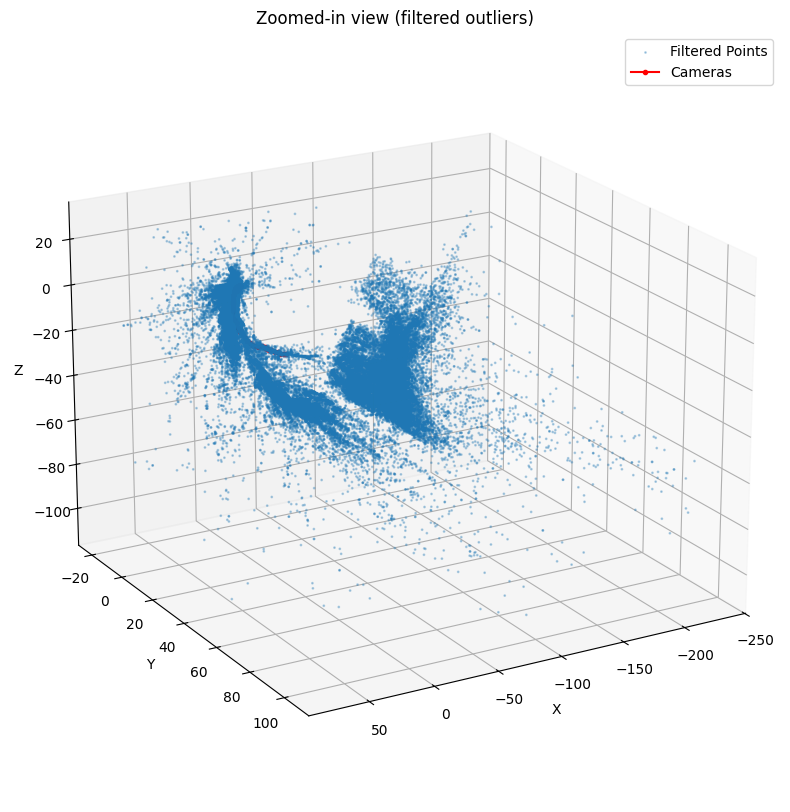

In [41]:
def zoom_point_cloud(all_points, cam_centers, percentile=99):
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt

    low = np.percentile(all_points, (100-percentile)/2, axis=0)
    high = np.percentile(all_points, 100 - (100-percentile)/2, axis=0)

    mask = np.all((all_points >= low) & (all_points <= high), axis=1)
    filtered = all_points[mask]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(filtered[:,0], filtered[:,1], filtered[:,2],
               s=1, alpha=0.3, label="Filtered Points")

    ax.plot(cam_centers[:,0], cam_centers[:,1], cam_centers[:,2],
            "-o", c="red", markersize=3, label="Cameras")

    ax.set_title("Zoomed-in view (filtered outliers)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    ax.view_init(elev=20, azim=60)
    plt.show()

zoom_point_cloud(all_points, cam_centers)


In [42]:
## these look ass so lets try and refine

In [43]:
import numpy as np
import cv2
from scipy.optimize import least_squares
from scipy.sparse import coo_matrix


In [44]:
cam_ids = sorted(cameras.keys())
cam_to_ba_idx = {cid: i for i, cid in enumerate(cam_ids)}
num_cams = len(cam_ids)
print("[BA] num_cams =", num_cams)

point_ids = sorted(points3d.keys())
pid_to_ba_idx = {pid: i for i, pid in enumerate(point_ids)}
num_points = len(point_ids)
print("[BA] num_points =", num_points)

# 3) Build BA observations: (cam_idx_local, pt_idx_local, u_meas, v_meas)
ba_observations = []

for pid in point_ids:
    if pid not in observations:
        continue
    pt_local = pid_to_ba_idx[pid]
    for (img_idx, kp_idx) in observations[pid]:
        if img_idx not in cam_to_ba_idx:
            continue
        cam_local = cam_to_ba_idx[img_idx]
        kp = all_kps[img_idx][kp_idx]
        u_meas, v_meas = kp.pt
        ba_observations.append((cam_local, pt_local, u_meas, v_meas))

ba_observations = np.array(ba_observations, dtype=float)
print("[BA] num_observations =", len(ba_observations))


[BA] num_cams = 63
[BA] num_points = 82944
[BA] num_observations = 165888


In [45]:
def rt_to_params(R, t):
    rvec, _ = cv2.Rodrigues(R)
    return np.hstack([rvec.flatten(), t.flatten()])


def params_to_rt(p):
    """6D param -> (R, t)"""
    rvec = p[:3].reshape(3, 1)
    t = p[3:].reshape(3, 1)
    R, _ = cv2.Rodrigues(rvec)
    return R, t


cam_params_init = np.zeros((num_cams, 6), dtype=np.float64)
for cid, ba_idx in cam_to_ba_idx.items():
    R_i, t_i = cameras[cid]
    cam_params_init[ba_idx] = rt_to_params(R_i, t_i)

point_params_init = np.zeros((num_points, 3), dtype=np.float64)
for pid, pidx in pid_to_ba_idx.items():
    point_params_init[pidx] = points3d[pid]


def pack_params(cam_params, point_params):
    return np.hstack([cam_params.ravel(), point_params.ravel()])


def unpack_params(x):
    params_per_cam = 6
    cam_size = num_cams * params_per_cam

    cam_flat = x[:cam_size]
    pts_flat = x[cam_size:]

    cam_params = cam_flat.reshape((num_cams, params_per_cam))
    point_params = pts_flat.reshape((num_points, 3))

    return cam_params, point_params


x0 = pack_params(cam_params_init, point_params_init)
print("[BA] total parameters =", x0.size)


[BA] total parameters = 249210


In [46]:
def project_point(K, cam_param, point_3d):
    R, t = params_to_rt(cam_param)
    X = point_3d.reshape(3, 1)                
    x_cam = R @ X + t                       
    z = x_cam[2, 0] + 1e-8                   

    u = K[0, 0] * x_cam[0, 0] / z + K[0, 2]
    v = K[1, 1] * x_cam[1, 0] / z + K[1, 2]
    return u, v


def ba_residuals(x, K, ba_observations):
    cam_params, point_params = unpack_params(x)
    residuals = np.empty(2 * len(ba_observations), dtype=np.float64)

    for i, (cam_idx, pt_idx, u_meas, v_meas) in enumerate(ba_observations):
        cam_idx = int(cam_idx)
        pt_idx = int(pt_idx)

        u_pred, v_pred = project_point(K, cam_params[cam_idx], point_params[pt_idx])

        residuals[2 * i]     = u_meas - u_pred
        residuals[2 * i + 1] = v_meas - v_pred

    return residuals


In [47]:
m = 2 * len(ba_observations)    
n = x0.size                    

rows = []
cols = []

for obs_idx, (cam_idx, pt_idx, u_meas, v_meas) in enumerate(ba_observations):
    cam_idx = int(cam_idx)
    pt_idx = int(pt_idx)

    row_u = 2 * obs_idx
    row_v = 2 * obs_idx + 1

    cam_col0 = cam_idx * 6

    pt_col0 = num_cams * 6 + pt_idx * 3

    for j in range(6):
        rows.append(row_u)
        cols.append(cam_col0 + j)
        rows.append(row_v)
        cols.append(cam_col0 + j)

    for j in range(3):
        rows.append(row_u)
        cols.append(pt_col0 + j)
        rows.append(row_v)
        cols.append(pt_col0 + j)

data = np.ones(len(rows), dtype=np.float64)
A = coo_matrix((data, (rows, cols)), shape=(m, n))

print("[BA] Sparsity matrix shape:", A.shape)
print("[BA] Non-zeros:", A.nnz)


[BA] Sparsity matrix shape: (331776, 249210)
[BA] Non-zeros: 2985984


In [48]:
print("[BA] Starting global bundle adjustment...")

result = least_squares(
    ba_residuals,
    x0,
    jac_sparsity=A,
    args=(K, ba_observations),
    method='trf',
    loss='soft_l1',    
    f_scale=1.0,
    x_scale='jac',
    ftol=1e-4,
    xtol=1e-4,
    gtol=1e-4,
    max_nfev=30,
    verbose=2
)

print("[BA] Finished. success =", result.success)
print("[BA] Final cost =", result.cost)


[BA] Starting global bundle adjustment...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.7885e+06                                    6.22e+10    
       1              5         3.8147e+06      2.97e+06       8.18e+03       1.83e+09    
       2              6         3.6260e+06      1.89e+05       1.67e+03       6.74e+08    
       3              7         2.5123e+06      1.11e+06       1.74e+03       5.01e+06    
       4             10         2.2988e+06      2.14e+05       2.68e+01       4.74e+06    
       5             11         2.1951e+06      1.04e+05       9.33e+00       4.78e+06    
       6             12         2.1504e+06      4.47e+04       8.26e+00       4.59e+06    
       7             13         2.1326e+06      1.78e+04       2.66e+00       4.58e+06    
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 6.7885e+06, final cost 2.1326e+06, first-order optimality 

In [49]:
cam_params_opt, point_params_opt = unpack_params(result.x)

for cid, ba_idx in cam_to_ba_idx.items():
    R_opt, t_opt = params_to_rt(cam_params_opt[ba_idx])
    cameras[cid] = (R_opt, t_opt)

for pid, pidx in pid_to_ba_idx.items():
    points3d[pid] = point_params_opt[pidx]

print("[BA] Updated cameras and 3D points with optimized values.")


def compute_reprojection_errors(cameras, points3d, K, ba_observations):
    errs = []
    for (cam_idx, pt_idx, u_meas, v_meas) in ba_observations:
        cam_idx = int(cam_idx)
        pt_idx = int(pt_idx)
        cam_param = cam_params_opt[cam_idx] 
        X = point_params_opt[pt_idx]
        u_pred, v_pred = project_point(K, cam_param, X)
        errs.append(np.sqrt((u_meas - u_pred)**2 + (v_meas - v_pred)**2))
    return np.array(errs)

errs_before = compute_reprojection_errors(cameras, points3d, K, ba_observations)  
print("[BA] Before: mean =", np.mean(errs_before), "median =", np.median(errs_before))



[BA] Updated cameras and 3D points with optimized values.
[BA] Before: mean = 11.433248299359631 median = 0.591726607324043


In [50]:
cam_params_opt, point_params_opt = unpack_params(result.x)

for cid, ba_idx in cam_to_ba_idx.items():
    R_opt, t_opt = params_to_rt(cam_params_opt[ba_idx])
    cameras[cid] = (R_opt, t_opt)

for pid, pidx in pid_to_ba_idx.items():
    points3d[pid] = point_params_opt[pidx]

print(" Updated cameras and 3D points with optimized values.")


 Updated cameras and 3D points with optimized values.


In [51]:
import numpy as np

# Camera centers
cam_ids = sorted(cameras.keys())
cam_centers = []

for cid in cam_ids:
    R, t = cameras[cid]
    C = -R.T @ t         
    cam_centers.append(C.reshape(3))

cam_centers = np.array(cam_centers)

point_ids = sorted(points3d.keys())
all_points = np.array([points3d[pid] for pid in point_ids])

print("Num cameras:", cam_centers.shape[0])
print("Num 3D points:", all_points.shape[0])


Num cameras: 63
Num 3D points: 82944


[INFO] Plotting 82944 points.
[INFO] Filtered 8295 outliers.


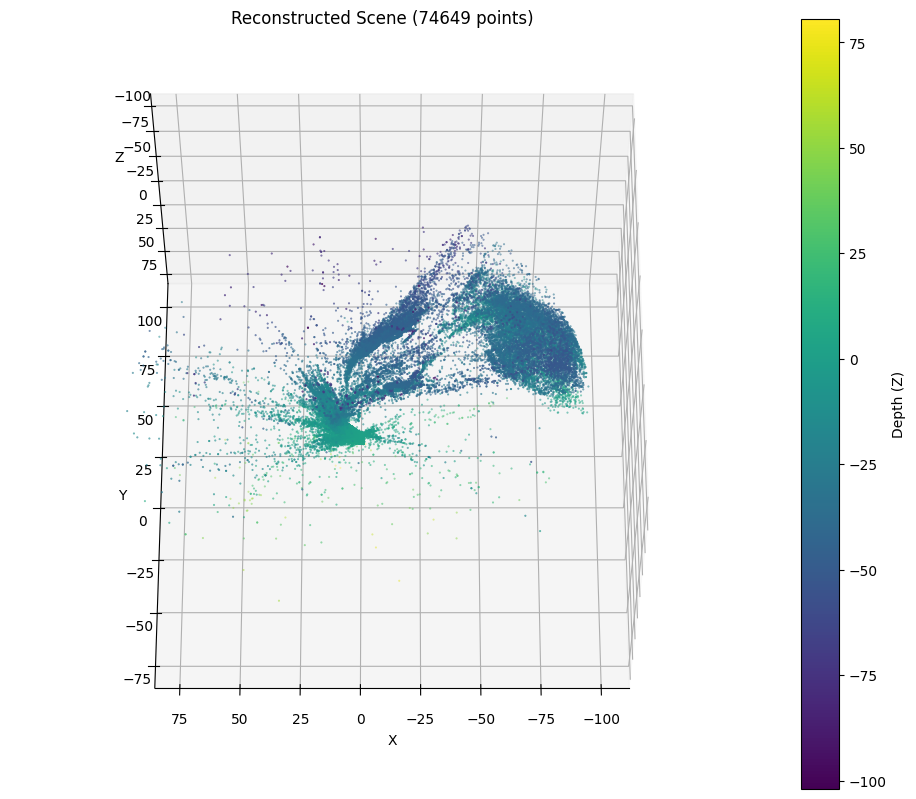

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

params_per_cam = 6 
cam_params_end = num_cams * params_per_cam

points_flat = result.x[cam_params_end:]

# Dynamically reshape: (Whatever_Length_Remains, 3)
points_3d = points_flat.reshape((-1, 3))

print(f"[INFO] Plotting {points_3d.shape[0]} points.")


center = np.median(points_3d, axis=0)
distances = np.linalg.norm(points_3d - center, axis=1)
mask = distances < np.percentile(distances, 90) 
points_clean = points_3d[mask]

print(f"[INFO] Filtered {len(points_3d) - len(points_clean)} outliers.")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(
    points_clean[:, 0], 
    points_clean[:, 1], 
    points_clean[:, 2], 
    s=1,                
    c=points_clean[:, 2],
    cmap='viridis',
    marker='.'
)


ax.set_title(f"Reconstructed Scene ({len(points_clean)} points)")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

all_limits = np.concatenate([points_clean[:,0], points_clean[:,1], points_clean[:,2]])
limit_range = np.ptp(all_limits) / 2
mid_x, mid_y, mid_z = np.mean(points_clean[:,0]), np.mean(points_clean[:,1]), np.mean(points_clean[:,2])

ax.set_xlim(mid_x - limit_range, mid_x + limit_range)
ax.set_ylim(mid_y - limit_range, mid_y + limit_range)
ax.set_zlim(mid_z - limit_range, mid_z + limit_range)

plt.colorbar(scatter, label='Depth (Z)')
ax.view_init(elev=240, azim=90)
plt.show()

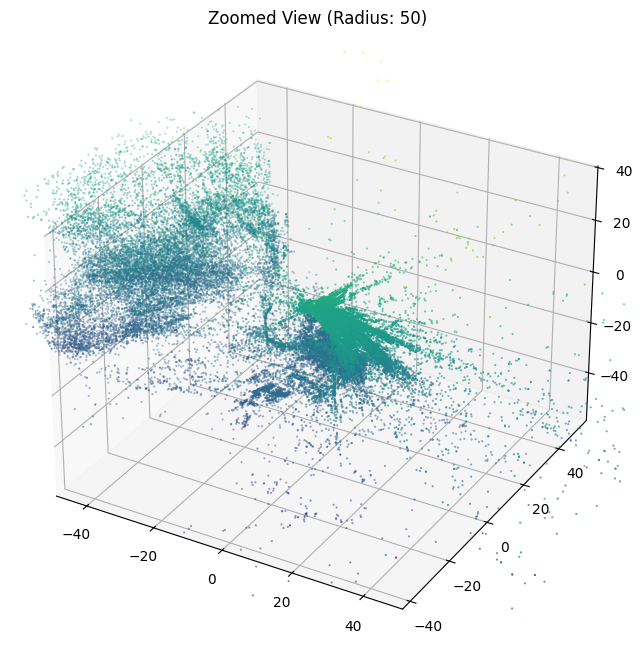

In [53]:
import matplotlib.pyplot as plt
import numpy as np


ZOOM_RADIUS =50 

params_per_cam = 6 
cam_params_end = num_cams * params_per_cam
points_3d = result.x[cam_params_end:].reshape((-1, 3))

center = np.median(points_3d, axis=0)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    points_clean[:, 0], 
    points_clean[:, 1], 
    points_clean[:, 2], 
    s=1,                   
    c=points_clean[:, 2],
    cmap='viridis',
    marker='.'
)

ax.set_xlim(center[0] - ZOOM_RADIUS, center[0] + ZOOM_RADIUS)
ax.set_ylim(center[1] - ZOOM_RADIUS, center[1] + ZOOM_RADIUS)
ax.set_zlim(center[2] - ZOOM_RADIUS, center[2] + ZOOM_RADIUS)

ax.set_title(f"Zoomed View (Radius: {ZOOM_RADIUS})")

plt.show()

C:\Users\pc\AppData\Local\Temp\ipykernel_24864\898196578.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


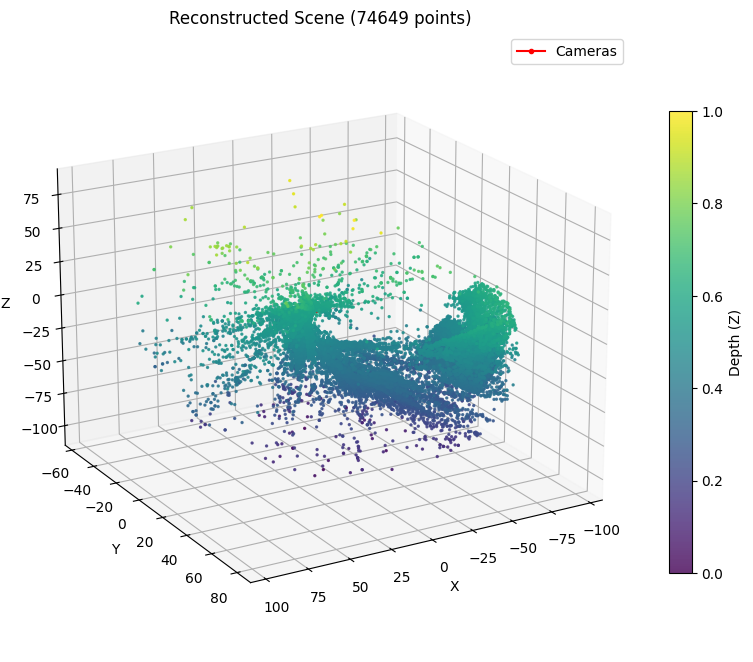

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np

pts = points_clean

# color by depth Z
z = pts[:, 2]
z_min, z_max = z.min(), z.max()
z_norm = (z - z_min) / (z_max - z_min + 1e-8)

cmap = cm.get_cmap('viridis')
colors = cmap(z_norm) 

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                c=colors, s=2, alpha=0.8)

ax.plot(cam_centers[:, 0],
        cam_centers[:, 1],
        cam_centers[:, 2],
        '-o', markersize=3, color='red', label='Cameras')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title(f"Reconstructed Scene ({pts.shape[0]} points)")
ax.legend()

cb = fig.colorbar(sc, shrink=0.6)
cb.set_label("Depth (Z)")

ax.view_init(elev=20, azim=60)
plt.show()


In [55]:
import numpy as np
import matplotlib.cm as cm

pts = points_clean


z = pts[:, 2]
z_min, z_max = z.min(), z.max()
z_norm = (z - z_min) / (z_max - z_min + 1e-8)

cmap = cm.get_cmap('viridis')
colors = cmap(z_norm)[:, :3]          
colors_255 = (colors * 255).astype(np.uint8)

def save_colored_ply(filename, points, colors):
    """
    points: (N, 3) float
    colors: (N, 3) uint8 (0–255)
    """
    N = points.shape[0]
    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {N}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        for (x, y, z), (r, g, b) in zip(points, colors):
            f.write(f"{x} {y} {z} {r} {g} {b}\n")

save_colored_ply("sfm_scene_colored_with_intrinsix.ply", pts, colors_255)
print("Saved colored point cloud to sfm_scene_colored.ply")


C:\Users\pc\AppData\Local\Temp\ipykernel_24864\2483169778.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


Saved colored point cloud to sfm_scene_colored.ply


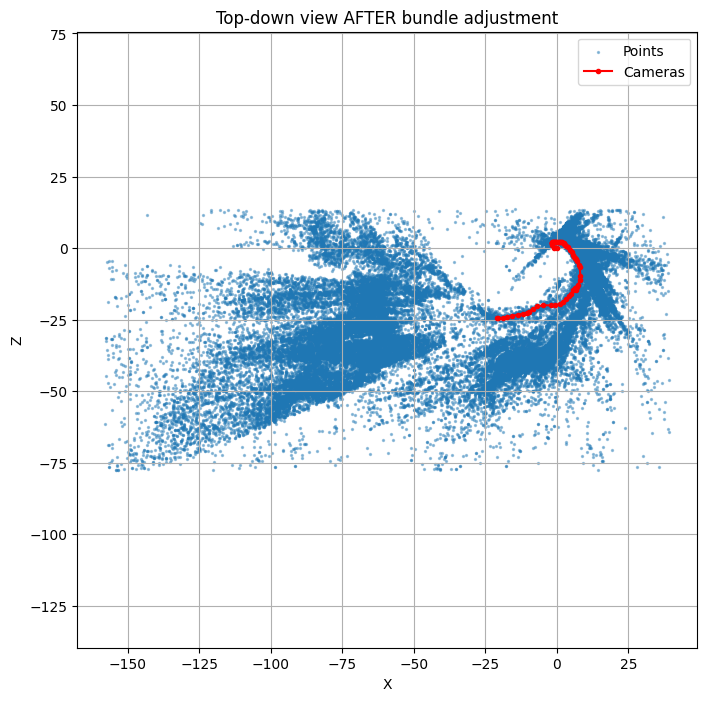

In [56]:
import matplotlib.pyplot as plt

low = np.percentile(all_points, 1, axis=0)
high = np.percentile(all_points, 99, axis=0)
mask = np.all((all_points >= low) & (all_points <= high), axis=1)
pts_filt = all_points[mask]

plt.figure(figsize=(8, 8))
plt.scatter(pts_filt[:, 0], pts_filt[:, 2],
            s=2, alpha=0.4, label="Points")
plt.plot(cam_centers[:, 0], cam_centers[:, 2],
         "-o", markersize=3, color="red", label="Cameras")

plt.xlabel("X")
plt.ylabel("Z")
plt.title("Top-down view AFTER bundle adjustment")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()
